# Notebook 1: Fleet Segmentation & Remaining Life Analysis.

This notebook lays the foundation for our DCF model. Before we can calculate cash flows, we must define our "Asset Roster"—the specific list of 415+ operational reactors that generate revenue.

Key Logic Applied:

* Filter: We only value "Operational" reactors.

* Performance Proxy: We calculate the 5-year average Load Factor for each reactor. This smooths out refueling outages and gives us a realistic "steady-state" performance metric for future revenue projection.

* Life Extension Logic: To estimate Remaining Life (our DCF projection period), we use a dynamic rule:

(Standard: Assume 60-year life.)

(De-Risked: If a reactor is already older than 50, we assume it has cleared regulatory hurdles and assign it an 80-year life.)

Block 1: Setup & Data Loading

We import our libraries and load the raw PRIS database.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set visualization style
sns.set_theme(style="whitegrid")

print("--- Notebook 1: Fleet Segmentation & Remaining Life Analysis ---")

# 1. Load the Dataset
file_path = '/content/Reactor Database - Pris.xlsx'
try:
    df_raw = pd.read_excel(file_path) # Changed to read_excel
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File {file_path} not found.")

# 2. Select Relevant Columns for Asset Valuation
cols_to_keep = [
    'Reactor name', 'Country', 'Status', 'Type',
    'Net Capacity, MWe', 'Grid Connection Date',
    'Year', 'Load Factor Annual'
]

# Check if columns exist
existing_cols = [c for c in cols_to_keep if c in df_raw.columns]
df_fleet = df_raw[existing_cols].copy()

print(f"Selected {len(existing_cols)} columns for analysis.")
print(df_fleet.head())

--- Notebook 1: Fleet Segmentation & Remaining Life Analysis ---
Data loaded successfully.
Selected 8 columns for analysis.
  Reactor name    Country       Status  Type  Net Capacity, MWe  \
0     ATUCHA-1  ARGENTINA  Operational  PHWR                340   
1     ATUCHA-1  ARGENTINA  Operational  PHWR                340   
2     ATUCHA-1  ARGENTINA  Operational  PHWR                340   
3     ATUCHA-1  ARGENTINA  Operational  PHWR                340   
4     ATUCHA-1  ARGENTINA  Operational  PHWR                340   

  Grid Connection Date    Year  Load Factor Annual  
0         19 Mar, 1974  1974.0                50.3  
1         19 Mar, 1974  1975.0                84.4  
2         19 Mar, 1974  1976.0                86.0  
3         19 Mar, 1974  1977.0                52.2  
4         19 Mar, 1974  1978.0                89.7  


Block 2: Data Cleaning & Operational Filter

We convert dates and filter the dataset to focus only on assets that are currently generating cash ("Operational").

In [3]:
print("Cleaning data...")

# 1. Convert Dates
df_fleet['Grid Connection Date'] = pd.to_datetime(df_fleet['Grid Connection Date'], format='%d %b, %Y', errors='coerce')

# 2. Clean Numeric Columns
# 'Load Factor Annual' might have non-numeric characters
df_fleet['Load Factor Annual'] = pd.to_numeric(df_fleet['Load Factor Annual'], errors='coerce')

# 3. Filter for Operational Reactors Only
# We only value assets that are currently generating cash
df_operational = df_fleet[df_fleet['Status'] == 'Operational'].copy()

# 4. Drop rows with missing critical data (Dates or Capacity)
df_operational = df_operational.dropna(subset=['Grid Connection Date', 'Net Capacity, MWe'])

print(f"Refined dataset to {df_operational['Reactor name'].nunique()} operational reactors.")

Cleaning data...
Refined dataset to 415 operational reactors.


Block 3: The Valuation Engine (Aggregating the Roster)

This is the core logic. We collapse the time-series data into a single row per reactor, calculating its Age, Remaining Life, and Stable Load Factor.

In [4]:
print("Generating Fleet Roster and calculating Valuation Metrics...")

# 1. Calculate Recent Performance (5-Year Average Load Factor)
# We want the most recent "stable" performance profile for our revenue projection
def get_recent_performance(group):
    # Sort by year descending to get latest data
    latest_data = group.sort_values('Year', ascending=False).head(5)
    avg_lf = latest_data['Load Factor Annual'].mean()
    return avg_lf

# Group by reactor to get performance
performance_metrics = df_operational.groupby('Reactor name').apply(get_recent_performance).reset_index(name='Avg_Load_Factor')

# 2. Get Static Assets Attributes
# We can just take the 'first' value since these don't change (Status is already filtered)
static_attributes = df_operational.groupby('Reactor name').first()[['Country', 'Type', 'Net Capacity, MWe', 'Grid Connection Date']].reset_index()

# 3. Merge to create the Roster
fleet_roster = pd.merge(static_attributes, performance_metrics, on='Reactor name')

# 4. Calculate Valuation Metrics
current_year = 2025 # Assuming valuation date is start of 2025
fleet_roster['Age'] = current_year - fleet_roster['Grid Connection Date'].dt.year

# Define Logic for Remaining Life (The "Assumed Life" logic)
# Rule: Standard is 60 years. If reactor is already old (>50), assume it got extended to 80.
fleet_roster['Assumed_Lifespan'] = np.where(fleet_roster['Age'] > 50, 80, 60)
fleet_roster['Remaining_Life'] = fleet_roster['Assumed_Lifespan'] - fleet_roster['Age']

# Clip Remaining Life at 0 (Valuation floor)
fleet_roster['Remaining_Life'] = fleet_roster['Remaining_Life'].clip(lower=0)

print(f"Roster complete. {len(fleet_roster)} assets valuated.")
print(fleet_roster[['Reactor name', 'Age', 'Remaining_Life', 'Avg_Load_Factor']].head(10))

Generating Fleet Roster and calculating Valuation Metrics...
Roster complete. 415 assets valuated.
           Reactor name  Age  Remaining_Life  Avg_Load_Factor
0  AKADEMIK LOMONOSOV-1    6              54            35.62
1  AKADEMIK LOMONOSOV-2    6              54            27.04
2             ALMARAZ-1   44              16            85.84
3             ALMARAZ-2   42              18            90.14
4               ANGRA-1   43              17            87.52
5               ANGRA-2   25              35            82.34
6                 ANO-1   51              29            91.30
7                 ANO-2   47              13            88.54
8            ARMENIAN-2   45              15            66.66
9                ASCO-1   42              18            84.46


/tmp/ipython-input-4214367096.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  performance_metrics = df_operational.groupby('Reactor name').apply(get_recent_performance).reset_index(name='Avg_Load_Factor')


Block 4: Visualization & Export

We visualize the "Asset Cliff" to understand the maturity of the fleet and save our roster for Notebook 2.

Visualizing Fleet Asset Profile...


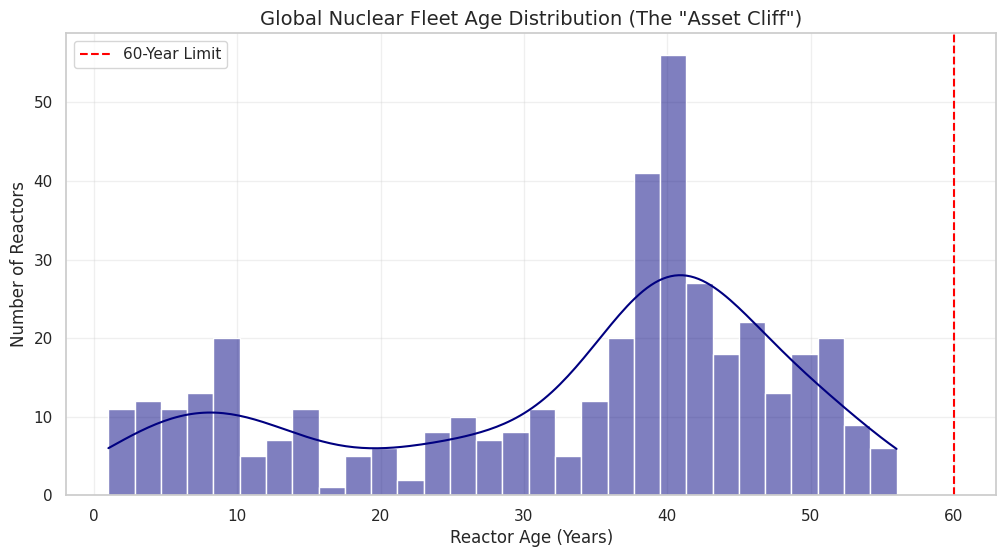

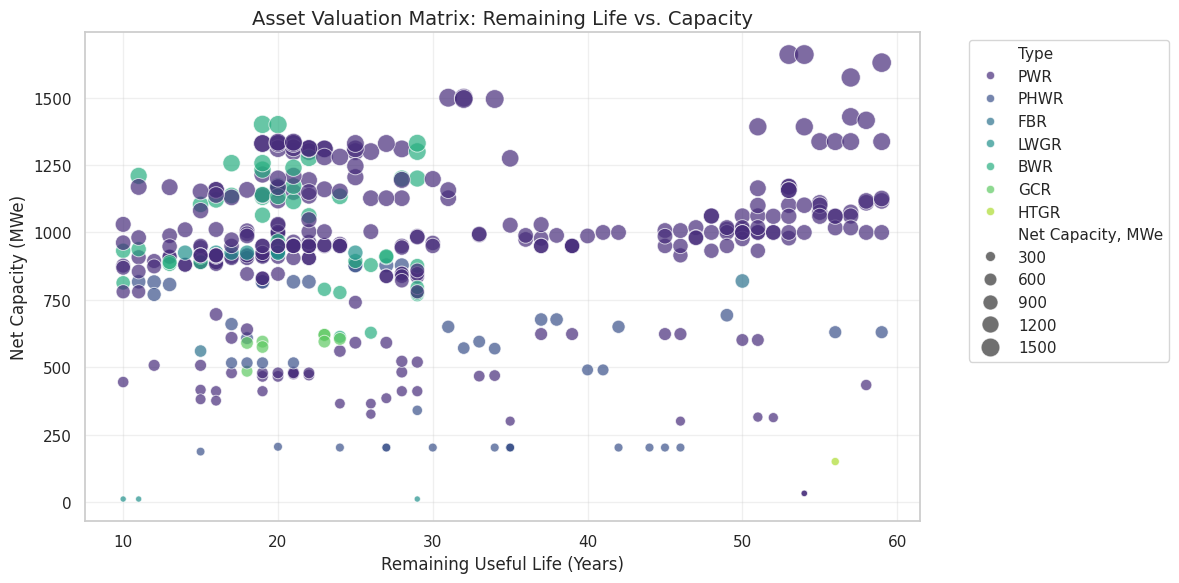

Fleet Roster saved to 'fleet_roster.csv'. Ready for Notebook 2.


In [5]:
print("Visualizing Fleet Asset Profile...")

# 1. Plot: The Asset Cliff (Age Distribution)
plt.figure(figsize=(12, 6))
sns.histplot(data=fleet_roster, x='Age', bins=30, kde=True, color='navy')
plt.axvline(x=60, color='red', linestyle='--', label='60-Year Limit')
plt.title('Global Nuclear Fleet Age Distribution (The "Asset Cliff")', fontsize=14)
plt.xlabel('Reactor Age (Years)')
plt.ylabel('Number of Reactors')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Plot: Remaining Life vs. Capacity (Valuation Matrix)
# High Capacity + Long Life = Most Valuable Assets
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=fleet_roster,
    x='Remaining_Life',
    y='Net Capacity, MWe',
    hue='Type',
    size='Net Capacity, MWe',
    sizes=(20, 200),
    alpha=0.7,
    palette='viridis'
)
plt.title('Asset Valuation Matrix: Remaining Life vs. Capacity', fontsize=14)
plt.xlabel('Remaining Useful Life (Years)')
plt.ylabel('Net Capacity (MWe)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Export
fleet_roster.to_csv('fleet_roster.csv', index=False)
print("Fleet Roster saved to 'fleet_roster.csv'. Ready for Notebook 2.")

Analysis of Results:

* The Asset Cliff: The histogram reveals a massive cluster of reactors between 30 and 50 years old. These assets are the "cash cows" of the industry today, but they represent a significant "Valuation Cliff" in the next 10-20 years if they are not replaced or extended.

* The Valuation Matrix: The scatter plot identifies our "Crown Jewels"—reactors with high capacity (>1000 MWe) and long remaining life (>40 years). These are predominantly the newer fleets in China and South Korea.